# NLP model building with long short term memory LSTM

Purpose : Building a model able to do a classification on sentences

## 0 - Interesting links

* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
* https://www.hackdeploy.com/keras-lstm-example-sequence-binary-classification/
* https://www.youtube.com/watch?v=A9QVYOBjZdY&ab_channel=TensorFlow
* https://www.youtube.com/watch?v=ZMudJXhsUpY&ab_channel=TensorFlow
* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17


To test different neural network architectures :
* https://keras-team.github.io/keras-tuner/
* https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

## 1 - Libraries import

In [88]:
import json
import random
import emoji
import emojis
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

## 2 - Variables definition

In [145]:
nb_train = 7000 # Number of training examples considered
nb_valid = 1500 # Number of validation examples considered
vocab_size = 10000 # Number of words to be considered regarding on their frequency
max_length = 100 # Maximum length of a sentence --> Size of entrance of neural network
embedding_dim = 8 # Embedding dimension for vector representation of words
nb_epochs = 40 # Number of epochs for training
batch_size = 256 # Number of training examples considered in mini batches during training

## 3 - Training JSON file reading

In [117]:
training_examples = []
URL = []
X = [] # sentences
Y = [] # positive or not

for line in open('review_amazon_ordinateurportable02_November_2020.json', 'r'):
    training_examples.append(json.loads(line))

training_examples = training_examples[0]

for item in training_examples:
    X.append(item['review'])    
    Y.append(item['positive'])

In [118]:
print("POSITIVE COMMENTS : \n" + "-"*120)
for i in range(10):
    if Y[i] == 1:
        print(X[i] + ' : ' + emoji.emojize(':thumbs_up:'))
        
    
print('\n' + '='*120 + '\n')

print("NEGATIVE COMMENTS : \n" + "-"*120)
for i in range(10):
    if Y[i] == 0:
        print(X[i] + ' : ' + emoji.emojize(':thumbs_down:'))

POSITIVE COMMENTS : 
------------------------------------------------------------------------------------------------------------------------
  6300 hundred processor is few generation old,  It should be priced 350 or 399 : 👍
  I ordered this yesterday and got it within 24 hours, I love it : 👍
  I bought this to replace a 2012 Mac Mini in our kitchen,It was over $500 - I wish it was a little cheaper, maybe $400, but at least it should last me 5+ years if nothing dies and I can easily use it with a TV if I want to change my use case : 👍
  So easy to use compared to Window  PC, I wanted to replace my All in one PC and the Chromebox with a monitor and speakers did the Job : 👍
  I bought this to play GeForce Now on since my old computer can't handle it, I recommend to anyone looking to PC game but don't wanna drop $1000 on a gaming rig : 👍
  Many more attachments can be used, I have a couple of extra monitors that work well with this : 👍
  Bought this for my son to use for school (since he

## 4 - Training / Test dataset splitting

In [119]:
training_examples = list(zip(X, Y))
random.shuffle(training_examples)
X, Y = zip(*training_examples)

X_train = list(X[0:nb_train])
Y_train = list(Y[0:nb_train])

X_valid = list(X[nb_train:nb_train + nb_valid])
Y_valid = list(Y[nb_train:nb_train + nb_valid])

X_test = list(X[nb_train + nb_valid:])
Y_test = list(Y[nb_train + nb_valid:])

## 5 - Sentences tokenization

In [120]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words = vocab_size) # Strategy for considering Out Of Vocabulary words
tokenizer.fit_on_texts(X_train) # Only considering words in training examples
word_index = tokenizer.word_index

# Pre-processing training set:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing validation set:
X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing test set:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length, padding = 'post', truncating = 'post')

## 6 - Model architecture definition

In [146]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    #tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 16)                1088      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 81,105
Trainable params: 81,105
Non-trainable params: 0
_________________________________________________________________


## 7 - Model training

In [148]:
callback_list = []

callback_list.append(EarlyStopping(monitor = 'val_loss', patience = 10, min_delta = 0.0, mode = 'min')) # Callback to ensure parameters update in accordance with test accuracy improvement
callback_list.append(CSVLogger('training_log.csv')) # Callback to get a feedback

In [149]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

history = model.fit(X_train, Y_train, epochs = nb_epochs, batch_size = batch_size, validation_data = (X_valid, Y_valid), verbose = 2, callbacks = callback_list)

Epoch 1/40
28/28 - 3s - loss: 0.6766 - accuracy: 0.6023 - val_loss: 0.6873 - val_accuracy: 0.5660
Epoch 2/40
28/28 - 2s - loss: 0.6613 - accuracy: 0.6021 - val_loss: 0.6722 - val_accuracy: 0.5660
Epoch 3/40
28/28 - 2s - loss: 0.6327 - accuracy: 0.6096 - val_loss: 0.6383 - val_accuracy: 0.5840
Epoch 4/40
28/28 - 2s - loss: 0.5581 - accuracy: 0.7287 - val_loss: 0.5856 - val_accuracy: 0.6840
Epoch 5/40
28/28 - 3s - loss: 0.4829 - accuracy: 0.8170 - val_loss: 0.5468 - val_accuracy: 0.7440
Epoch 6/40
28/28 - 2s - loss: 0.4200 - accuracy: 0.8490 - val_loss: 0.5207 - val_accuracy: 0.7573
Epoch 7/40
28/28 - 2s - loss: 0.3714 - accuracy: 0.8807 - val_loss: 0.5355 - val_accuracy: 0.7413
Epoch 8/40
28/28 - 3s - loss: 0.3297 - accuracy: 0.8944 - val_loss: 0.5383 - val_accuracy: 0.7407
Epoch 9/40
28/28 - 2s - loss: 0.3008 - accuracy: 0.9084 - val_loss: 0.5282 - val_accuracy: 0.7560
Epoch 10/40
28/28 - 2s - loss: 0.2764 - accuracy: 0.9167 - val_loss: 0.5322 - val_accuracy: 0.7553
Epoch 11/40
28/28 -

## 8 - Model training analysis

### 8.1 - Accuracy & Loss plots

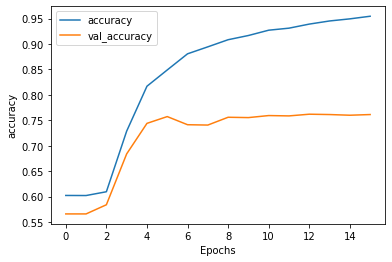

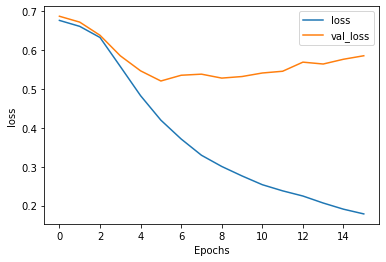

In [150]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 8.2 - Loading log file information

In [151]:
df_log = pd.read_csv('training_log.csv')
df_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.602286,0.676600,0.566000,0.687322
1,1,0.602143,0.661307,0.566000,0.672222
2,2,0.609571,0.632659,0.584000,0.638332
3,3,0.728714,0.558089,0.684000,0.585563
4,4,0.817000,0.482891,0.744000,0.546846
5,5,0.849000,0.419954,0.757333,0.520709
6,6,0.880714,0.371449,0.741333,0.535495
7,7,0.894429,0.329657,0.740667,0.538305
8,8,0.908429,0.300780,0.756000,0.528164
9,9,0.916714,0.276406,0.755333,0.532204


## 9 - Predictions on test set & new sentences

In [152]:
Y_test_prediction = np.round_(model.predict(X_test)[:,0])
conf_matrix = confusion_matrix(Y_test_prediction, Y_test)

print('CONFUSION MATRIX' + '\n' + '='*20)
print('TRUE POSITIVES : ' + str(conf_matrix[0][0]) + '\nFALSE POSITIVES : ' + str(conf_matrix[0][1]) + '\nFALSE NEGATIVES : ' + str(conf_matrix[1][0]) + '\nTRUE NEGATIVES : ' + str(conf_matrix[1][1]))
print('-'*20 + '\nACCURACY : ' + str(np.round_(100 * (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][0] + conf_matrix[0][1] + conf_matrix[1][1]),2)) + ' %')

CONFUSION MATRIX
TRUE POSITIVES : 128
FALSE POSITIVES : 47
FALSE NEGATIVES : 79
TRUE NEGATIVES : 255
--------------------
ACCURACY : 75.25 %


In [153]:
sentences = ['Awesome computer, definitely recommend it', 'Do not recommend it, very slow laptop', 'Do recommend it, not very slow laptop', 'so bad']
tokens = tokenizer.texts_to_sequences(sentences)
padded_tokens = pad_sequences(tokens, maxlen = max_length, padding = 'post', truncating = 'post')
predictions = list(np.reshape(model.predict(padded_tokens), len(sentences)))

for i in range(len(sentences)):
    if np.round(predictions[i]) == 1:
        print(sentences[i] + ' : ' + str(emoji.emojize(':thumbs_up:') + '\t (Trust : ' + str(np.round(100 * predictions[i],1)) + ' %)'))
    else:
        print(sentences[i] + ' : ' + str(emoji.emojize(':thumbs_down:') + '\t (Trust : ' + str(np.round(100 - (100 * predictions[i]),1)) + ' %)'))
    

Awesome computer, definitely recommend it : 👍	 (Trust : 89.1 %)
Do not recommend it, very slow laptop : 👎	 (Trust : 88.7 %)
Do recommend it, not very slow laptop : 👎	 (Trust : 90.1 %)
so bad : 👍	 (Trust : 58.2 %)


## 10 - Model parameters save 

In [154]:
model.save("seq_model.h5")

## 11 - Saved model loading

In [155]:
model = load_model('seq_model.h5')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 16)                1088      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 81,105
Trainable params: 81,105
Non-trainable params: 0
_________________________________________________________________
